In [1]:
import sys
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import time

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
from tqdm import tqdm

from jax.scipy.stats import norm

import utils
import metrics
import stein
import plot
import kernels
from svgd import SVGD

rkey = random.PRNGKey(1)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# KL divergence estimation

## KL between two discrete probability vectors

Let $X_1, \dots, X_n$ iid as $q$ and $Y_1, \dots, Y_n$ iid as $p$. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
\sum_{k=1}^K \hat q_k \log \frac{\hat q_k}{\hat p_k},
$$
where $\hat q$ and $\hat p$ are vectors in $\mathbb R^K$ representing histogram estimates of $q$ and $p$ with $K$ bins, computed using the samples $X_i$ and $Y_i$.

In [2]:
def get_bins_and_bincounts(samples, normalized=False):
    """take in samples, create a common set of bins, and compute the counts count(x in bin)
    for each bin and each sample x.
    Parameters
    ------------
    samples : np.array of shape (n,) or shape (k, n).
    - If shape (n,): interpreted as a set of n scalar-valued samples.
    - If shape (k, n): interpreted as k sets of n scalar-valued samples.
    
    Returns
    --------
    probabilities :
    bins :
    """
    nr_samples = np.prod(samples.shape)
    nr_bins = np.log2(nr_samples)
    nr_bins = int(max(nr_bins, 5))
    
    lims = [np.min(samples), np.max(samples)]
    bins = np.linspace(*lims, num=nr_bins)
    
    if samples.ndim == 2:
        out = np.asarray([np.histogram(x, bins=bins, density=normalized)[0] for x in samples])
        return out, bins
    elif samples.ndim == 1:
        return np.histogram(samples, bins=bins, density=normalized)[0], bins
    else:
        raise ValueError(f"Input must have shape (n,) or shape (k,n). Instead received shape {samples.shape}")
        
# get_bins_and_bincounts = jit(get_bins_and_bincounts)

In [3]:
def smooth_and_normalize(vec, normalize=True):
    """
    Parameters:
    * vec : np.array of shape (n,)
    * normalize : bool
    
    Returns:
    out : np.array of shape (n,).
    If vec_i = 0, then out_i = epsilon. If vec_i !=0, then out_i = vec_i - c.
    c is chosen such that sum(vec) == 1.
    """
    vec = np.asarray(vec, dtype=np.float32)
    
    if normalize:
        vec = vec / vec.sum()
    n = len(vec)
    epsilon = 0.0001
    num_nonzero = np.count_nonzero(vec)
    c = epsilon * (n - num_nonzero) / num_nonzero
    perturbation =  (vec == 0)*epsilon - (vec != 0)*c
    return vec + perturbation

In [4]:
def kl_from_probabilities(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=(k,)
    Discrete probability distributions. Can be unnormalized.
    """
    p = np.asarray(p, dtype=np.float32)
    q = np.asarray(q, dtype=np.float32)
    if p.shape != q.shape:
        raise ValueError("p and q need to have same shape.")
    elif p.ndim > 1:
        raise ValueError(f"Inputs need to be one-dimensional vectors.")
        
    p, q = [smooth_and_normalize(prob) for prob in (p, q)]
    
#     return np.sum(p * np.log(p/q))
    return np.sum(p * (np.log(p) - np.log(q)))

In [5]:
@jit
def kl_from_samples(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=(n,). iid samples from p and q.
    """
    samples = np.stack([p, q])
    vals, _ = get_bins_and_bincounts(samples)
    pprobs, qprobs = vals

    return kl_from_probabilities(pprobs, qprobs)

## KL between sample and continuous density using histogram estimate

Let $X_1, \dots, X_n$ iid as $q$. Assume density $p$ is known. Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by

$$
1/n \sum_i \log \hat q(X_i) - \log p(X_i),
$$
where $\hat q$ is a histogram estimate of $q$ based on the samples $X_i$.

Note: 
* this estimate is sensitive to the method used to determine the number of histogram bins $K$. Empirically, $K = \log_2(n)$ gives good results, while $K = n / 10$ or $K = \sqrt n$ don't.
* A reasonable bound on the bias of a histogram estimate $\hat q$ is
$$E[\hat q(x)] - q(x)\leq \frac{L}{K},$$
where $L = \sup_x \vert q'(x) \vert$. ([reference](https://faculty.washington.edu/yenchic/18W_425/Lec6_hist_KDE.pdf))
* The pointwise variance of histogram estimate $\hat q$ grows linearly with number of bins $K$.
* This is a special case of the kernel density estimator below, with kernel 
$$
k(x, y) = \begin{cases} 1/B_{xy} & \text{ if $x$ and $y$ are in the same bin} \\ 0 & \text{ otherwise.} \end{cases}
$$
where $B$ is the width of the interval corresponding to the bin containing $x$ and $y$.

In [6]:
def get_histogram_likelihoods(q):
    """
    Parameters:
    * q : np.array of scalar-valued samples from distribution q.
    
    Returns:
    np.array of same length as q, consisting of an approximation of the pdf q(x_i) at the (sorted) samples x_i
    """
    q = np.asarray(q, dtype=np.float32)
    n = len(q) 
    
    bincounts, bins = get_bins_and_bincounts(q)
    bincounts = np.array(bincounts, dtype=np.int32)
    likelihoods = smooth_and_normalize(bincounts) / np.diff(bins)
    
    sample_likelihoods = np.repeat(likelihoods, bincounts)
    return sample_likelihoods

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


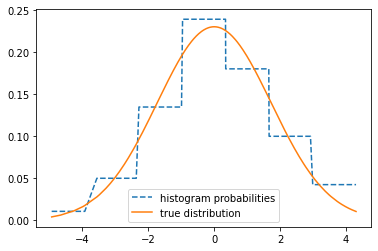

In [7]:
dist = metrics.Gaussian(0, 3)
s = dist.sample(500)
s = s[:, 0]
sample_probabilities = get_histogram_likelihoods(s)
s = s.sort()
plt.plot(s, sample_probabilities, "--", label="histogram probabilities")
plt.plot(s, vmap(dist.pdf)(s), "-", label="true distribution")
plt.legend()

In [8]:
np.sum(sample_probabilities[1:] * np.diff(s)) # needs to equal 1

DeviceArray(1.0159463, dtype=float32)

In [9]:
def kl_sample_and_density(q, logp):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution q.
    logp : callable. Takes one argument, computes log(p(x))
    """
    histogram_likelihoods = get_histogram_likelihoods(q)
    return np.mean(np.log(histogram_likelihoods) - vmap(logp)(q))

## KL (between sample and density) using interpolated CDF

A variation on the above approach. Let $X_1, \dots, X_n$ iid as $q$ and assume $p$ is known. Write $\mathbb Q_n$ for the empirical CDF of the $X_i$. Now define $\hat Q$ to be equal to $\mathbb Q_n$ when evaluated at one of the samples and linearly interpolated in between.

We can then approximate $q$ by the derivative $\hat q = \frac{d \hat Q}{dx}$. This is easy to evaluate since $\hat Q$ is piecewise linear.

Then an estimator for $\text{KL}(q \ \Vert \ p)$ is given by
$$
1/n \sum_{i=1}^n \log \frac{\hat q(X_i)}{p(X_i)}.
$$
Note that
$$
\hat q(X_i) = \frac{1/n}{X_i - X_{i-1}}.
$$

Unfortunately this approach is unstable: it gives very high values for $\hat q$ whenever two samples lie very close to each other. A better version might be to estimate

$$
\frac{q(X_i)}{p(X_i)} \approx \frac{1/n}{P(X_i) - P(X_{i-1})}
$$
where $P$ is the (known) CDF of $p$.

In [10]:
def get_interpolated_loglikelihoods(q):
    """
    Parameters:
    * samples : array-like, shape (n,). Set of n scalar-valued samples.
    
    Returns:
    An estimate of the loglikelihood log q(x) for each x in samples. Sorted from least to greatest sample.
    """
    q = np.asarray(q, dtype=np.float32)
    n = len(q)
    
    diffs = np.diff(q.sort())
    diffs = smooth_and_normalize(diffs, normalize=False)
    logpdf_estimate = -np.log(n) - np.log(diffs)
    
    return np.concatenate([logpdf_estimate[0, np.newaxis], logpdf_estimate])

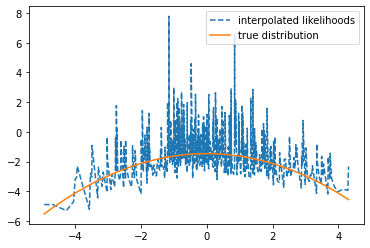

In [11]:
dist = metrics.Gaussian(0, 3)
s = dist.sample(500)[:, 0]
sample_likelihoods = get_interpolated_loglikelihoods(s)
s = s.sort()
plt.plot(s, sample_likelihoods, "--", label="interpolated likelihoods")
plt.plot(s, vmap(dist.logpdf)(s), "-", label="true distribution")
plt.legend()

In [12]:
np.sum(np.exp(sample_likelihoods[1:]) * np.diff(s))

DeviceArray(0.99800014, dtype=float32)

In [13]:
def kl_using_interpolated_cdf(q, logp):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution q.
    logp : callable. Takes one argument, computes log(p(x))
    """
    histogram_loglikelihoods = get_interpolated_loglikelihoods(q)
    return np.mean(histogram_loglikelihoods - vmap(logp)(q))

### Try other interpolating approach:

In [14]:
def get_interpolated_likelihood_ratio(samples, p_cdf):
    """
    Parameters:
    * samples : array-like, shape (n,). Set of n scalar-valued samples.
    * p_cdf : callable, takes in one scalar argument x and returns CDF of p at x.
    
    Returns:
    An estimate of the log likelihood rato log q(x)/p(x) for each x in samples. Sorted from least to greatest sample.
    """
    samples = np.asarray(samples, dtype=np.float32)
    n = len(samples)
    
    pdiffs = np.diff(vmap(p_cdf)(samples.sort()))
    ratio_estimate = -np.log(n) - np.log(pdiffs)
#     return ratio_estimate
    return np.concatenate([ratio_estimate[0, np.newaxis], ratio_estimate]) # make sure length is n

In [15]:
q = metrics.Gaussian(-3, 1) 
s = q.sample(500)[:, 0]

def logratio(x):
    """q(x)/p(x)"""
    return (9-6*x)/2

likelihood_ratio = get_interpolated_likelihood_ratio(s, norm.cdf)
s = s.sort()
true_likelihood_ratio = vmap(logratio)(s)

# plt.plot(s, sample_likelihoods, "--", label="interpolated likelihoods")


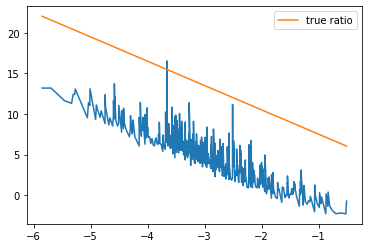

In [16]:
plt.plot(s, likelihood_ratio)
plt.plot(s, true_likelihood_ratio, "-", label="true ratio")
# plt.yscale("log")
plt.legend()

## KL (between sample and density) using Kernel Density Estimation

Let $X_1, \dots, X_n$ iid as $q$. Assume density $p$ is known. Then an estimator for for $q$ is given by
$$
\hat q(x) = \frac{1}{n} \sum_{i=1}^n k(x, X_i),
$$
where $k$ is some P.D. kernel function. An estimator for $\text{KL}(q \ \Vert \ p)$ is then given by
$$
1/n \sum_i \log \hat q(X_i) - \log p(X_i).
$$
Note:
* This takes $ O (n^2)$ to evaluate.

In [17]:
def get_kde_likelihoods(samples, kernel):
    """
    Parameters:
    * samples : array-like, shape (n,). Set of n scalar-valued samples.
    * kernel : callable, takes in two scalar arguments x and y. Computes kernel k(x, y). Must be normalized,
    that is for all $y$ we have $\int k(x, y) dx = 1$.
    
    Returns:
    An estimate of the likelihood q(x) for each x in samples. Same order as the samples.
    """
    samples = np.asarray(samples, dtype=np.float32)
    n = len(samples)
    kernelv = vmap(kernel, (0, None))
    kernelvv = vmap(kernelv, (None, 0))
    
    return np.squeeze(np.mean(kernelvv(samples, samples), axis=0))

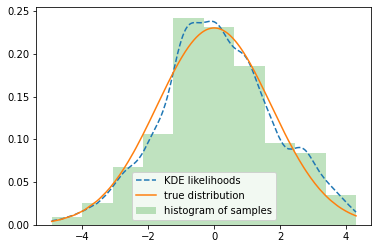

In [18]:
dist = metrics.Gaussian(0, 3)
s = dist.sample(500)[:, 0]
h = 0.1
logh = np.log(h)
kernel = lambda x, y: kernels._ard(x, y, logh) / np.sqrt(2 * np.pi * h)
sample_likelihoods = get_kde_likelihoods(s, kernel)
sorted_idx = np.argsort(s)
s = s[sorted_idx]
sample_likelihoods = sample_likelihoods[sorted_idx]

plt.plot(s, sample_likelihoods, "--", label="KDE likelihoods")
plt.plot(s, vmap(dist.pdf)(s), "-", label="true distribution")
plt.hist(s, alpha=0.3, label="histogram of samples", density=True)
plt.legend()

In [19]:
def kl_using_kde(q, logp, kernel):
    """Kullback-Leibler divergence D(q || p) between sample p and cts density q
    Parameters
    ----------
    q : array-like, shape (d,). Samples from distribution q.
    logp : callable. Takes one argument, computes log(p(x))
    kernel : callable, takes in two scalar arguments x and y. Computes kernel k(x, y). Must be normalized,
    that is for all $y$ we have $\int k(x, y) dx = 1$.
    """
    kde_likelihoods = get_kde_likelihoods(q, kernel)
    return np.mean(np.log(kde_likelihoods) - vmap(logp)(q))
kl_using_kde = jit(kl_using_kde, static_argnums=(1,2))

## Analytic KL of two Gaussians

This is the exact value for $\text{KL}(q \ \Vert \ p)$ where $q$ and $p$ are both Gaussian.

In [20]:
@jit
def kl_of_gaussian(p, q):
    """
    Parameters
    ----------
    p, q : array-like, parameters of gaussian: p = [mu, var], q = [mu2, var2]
    """
    mu1, var1 = p
    mu2, var2 = q
    sigma1, sigma2 = [np.sqrt(v) for v in (var1, var2)]
    out =  np.log(sigma2 / sigma1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 1/2
    return np.squeeze(out)

## KL estimate using fitted Gaussian parameters

In [21]:
def fit_gaussian(samples):
    """
    Parameters
    ----------
    samples : array-like, shape (n,)
    """
    samples = np.asarray(samples)
    return np.array([np.mean(samples), np.var(samples)])

# Multidimensional KDE

In [23]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# sample data
d = metrics.Gaussian([0, 0], [1,1])
x = d.sample(500)

# instantiate, crossvalidate, and fit the KDE model
kde = KernelDensity(kernel='gaussian')
bandwidths = 10 ** onp.linspace(-1, 1, 100)
metric_params = {
    "p": 2,
    "w": [1,2],
}
grid = GridSearchCV(KernelDensity(kernel='gaussian', 
                                  metric="wminkowski",
                                  metric_params=metric_params),
                    {'bandwidth': bandwidths})
grid.fit(x)
grid.best_params_
kde = grid.best_estimator_
kde.fit(x)

# # score_samples returns the log of the probability density
# x_d = np.linspace(-7, 8, 2000)
# logprob = kde.score_samples(x_d[:, None])

# plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
# plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
# plt.plot(x_d, vmap(d.pdf)(x_d))
# # plt.ylim(-0.02, 0.22)

KernelDensity(bandwidth=0.5094138014816381, metric='wminkowski',
              metric_params={'p': 2, 'w': [1, 2]})

In [ ]:
def get_kde_loglikelihoods(samples):
    """
    samples: array of shape (n, d) drawn from distribution q.
    
    Return:
    KDE estimate of loglikelihood q(x) for each x in samples.
    """
    # instantiate, crossvalidate, and fit the KDE model
    bandwidths = 10**onp.linspace(-2, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths})
    grid.fit(samples)
    kde = grid.best_estimator_
    kde.fit(samples)
    return kde.score_samples(samples)

## Test KL estimate for a range of sample sizes

In [ ]:
def test_kl(qdist, pdist, ngrid, kernel):
    """compute estimated KL(q || p) for a range of sample sizes"""
    ppars, qpars = [(dist.mean, dist.cov) for dist in (pdist, qdist)]
    true_kl = kl_of_gaussian(qpars, ppars)
    
    kls_samples = []
    kls_sample_and_density = []
    kls_using_fit = []
    kls_interpolated = []
    kls_kde = []
    
    mses = []
    for n in tqdm(ngrid):
        qs, ps = [dist.sample(n)[:, 0] for dist in (qdist, pdist)]
        
        kls_samples.append(kl_from_samples(qs, ps))
        kls_sample_and_density.append(kl_sample_and_density(qs, pdist.logpdf))
        kls_using_fit.append(kl_of_gaussian(fit_gaussian(qs), ppars))
        kls_interpolated.append(kl_using_interpolated_cdf(qs, pdist.logpdf))
        kls_kde.append(kl_using_kde(qs, pdist.logpdf, kernel))
        
        mses.append([(est[-1] - true_kl)**2 for est in 
                     (kls_samples, kls_sample_and_density, 
                      kls_using_fit, kls_interpolated, kls_kde)])
        
    return mses, kls_samples, kls_sample_and_density, kls_using_fit, kls_interpolated, kls_kde, true_kl

def plot_results(ngrid, mses, kls_samples, kls_sample_and_density, kls_using_fit, kls_interpolated, kls_kde, true_kl):
    fig, axs = plt.subplots(1, figsize=[10, 6])
    ax = axs
#     ax.plot(ngrid, kls_samples, "--o", label="KL sample-sample")
    ax.plot(ngrid, kls_sample_and_density, "--o", label="KL sample-pdf")
    ax.plot(ngrid, kls_using_fit, "--o", label="KL using fitted gaussian")
#     ax.plot(ngrid, kls_interpolated, "--o", label="KL using interpolated CDF")
    ax.plot(ngrid, kls_kde, "--o", label="KL using KDE estimate of CDF")
    
    ax.set_xscale("log")
    ax.axhline(y=true_kl)
    ax.legend()
    
#     ax.set_ylim((true_kl-0.4, true_kl+0.4))

In [ ]:
# parameters (mean, variance)
ppar = (0, 6)
qpar = (-5, 1)

pdist = metrics.Gaussian(*ppar)
qdist = metrics.Gaussian(*qpar)

ngrid = np.logspace(1, 3, 30)
ngrid = np.array(ngrid, dtype=np.int32)

h = 0.1
logh = np.log(h)
kernel = lambda x, y: kernels._ard(x, y, logh) / np.sqrt(2 * np.pi * h)

In [ ]:
res = test_kl(qdist, pdist, ngrid, kernel)

In [ ]:
plot_results(ngrid, *res)

In [ ]:
res[-1]

## Implementation in `metrics.Distribution`

In [ ]:
ppar = (0, 6) # (mean, variance)
qpar = (0, 1)

pdist = metrics.Gaussian(*ppar)
qdist = metrics.Gaussian(*qpar)

n = 100
sample = qdist.sample((n,))
print("KL estimate:", pdist.kl_divergence(sample))
print("True KL:", kl_of_gaussian(qpar, ppar))

# KL Divergence of the Funnel distribution

In [ ]:
f = dist.Funnel(2)
